# Удержание клиентов фитнес-центров

**Заказчик** - сеть фитнес-центров *****.

**Цель** - провести анализ и подготовить план действий по удержанию клиентов фитнес-центров.

**Входные данные** - заказчик предоставил сведения в csv-файлах, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

**Ход исследования:**
1. Загрузка данных.
<br><br>
2. Исследовательский анализ данных (EDA):
    - есть ли в датасете отсутствующие признаки;
    - изучим средние значения и стандартные отклонения;
    - посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
    - построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
    - построим матрицу корреляций.
<br><br>
3. Построим модель прогнозирования оттока клиентов - бинарная классификация клиентов, где целевой признак — факт оттока клиента в следующем месяце:
    - разобъём данные на обучающую и валидационную выборку;
    - обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом;
    - оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели.
<br><br>
4. Проведём кластеризацию клиентов:
    - стандартизируем данные;
    - построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму и на основании полученного графика предположим, какое количество кластеров можно выделить;
    - обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (по договорённости число кластеров n=5 для возможности сравнения результатов с другими студентами);
    - изучим средние значения признаков для кластеров;
    - построим и изучим распределения признаков для кластеров;
    - для каждого полученного кластера посчитаем долю оттока. Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?
<br><br>
5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
try:
    df = pd.read_csv('./datasets/gym_churn.csv')
    print('Данные загружены локально')
except:
    df = pd.read_csv('https://*********************/gym_churn.csv')
    print('Данные загружены с сервера *******************')
df.head()

Данные загружены локально


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

Посмотрим на датасет.

In [3]:
print(df.shape[0], '- количество строк')
print(df.shape[1]-1, '- количество признаков')
df.head(5)

4000 - количество строк
13 - количество признаков


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Дубликатов нет:

In [4]:
df.duplicated().sum()

0

Пропусков нет:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Базовые статистики:

In [6]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Данные клиента за предыдущий до проверки факта оттока месяц:**
- `gender` — пол, значения 1 и 0 соответствует мужскому и женскому полу, однако соответствие 1 - муж. и 0 - жен. или наоборот нигде прямо не указано. Будем исходить из того, что естественной причиной для кодирования женщины = 0, а мужчины = 1 является анатомия, а также генами: пара половых хромосом X и Y, у женщин есть ХХ, а у мужчин - XY хромосомы. При X = 0 и Y = 1, женщина = XX = 00 = 0, мужчина = XY = 01 = 1;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

`Churn` — факт оттока в текущем месяце.

Столбцы имеют бинарные значения 0 или 1:
- `gender`;
- `Near_Location`;
- `Partner`;
- `Promo_friends`;
- `Phone`;
- `Group_visits`;
- `Churn`.

Столбцы имеют значения в некоторых диапазонах:
- `Age` [18, 41];
- `Lifetime` [0, 31]
- `Contract_period` [1, 6, 12]
- `Month_to_end_contract` [1, 12]
- `Avg_class_frequency_total` [0, 6.023668...]
- `Avg_class_frequency_current_month` [0, 6,146783...]
- `Avg_additional_charges_total` [0.148205..., 552.590740...]

Анализ столбцов с бинарными значениями:

In [7]:
columns = ['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits','Churn']
tmp = pd.DataFrame(data={'type':[0,1]}, index=[0, 1])

for col in columns:
    t = df.groupby(col)['Age'].count().reset_index()
    t = t.rename(columns={col:'type', 'Age':col+'_count'})
    tmp = tmp.merge(t)
columns = tmp.columns[1:]
for col in columns:
    tmp[col] = round(tmp[col]/4000*100, 1)
    tmp = tmp.rename(columns={col:col+'_perc'})
tmp.T

,0,1
type,0.0,1.0
gender_count_perc,49.0,51.0
Near_Location_count_perc,15.5,84.5
Partner_count_perc,51.3,48.7
Promo_friends_count_perc,69.2,30.8
Phone_count_perc,9.6,90.4
Group_visits_count_perc,58.8,41.2
Churn_count_perc,73.5,26.5


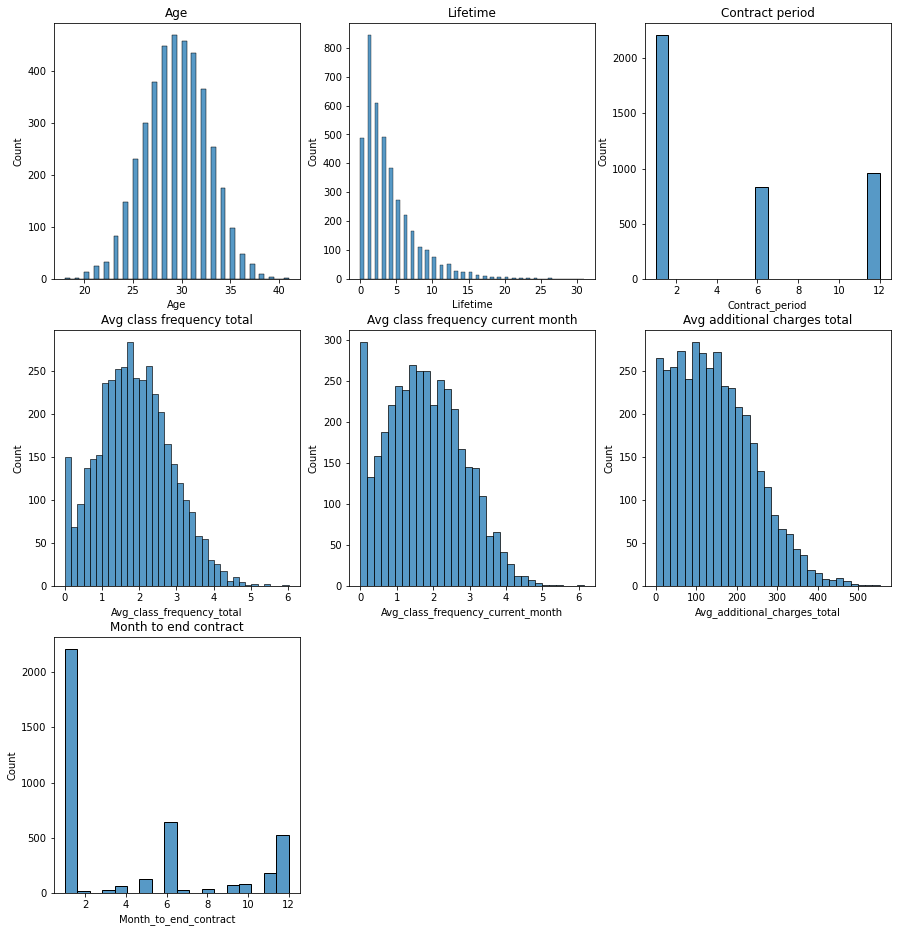

In [8]:
plt.figure(figsize=(15, 16))

plt.subplot(3, 3, 1)
sns.histplot(df['Age'])
plt.title('Age')

plt.subplot(3, 3, 2)
sns.histplot(df['Lifetime'])
plt.title('Lifetime')

plt.subplot(3, 3, 3)
sns.histplot(df['Contract_period'])
plt.title('Contract period')

# 

plt.subplot(3, 3, 4)
sns.histplot(df['Avg_class_frequency_total'])
plt.title("Avg class frequency total")

plt.subplot(3, 3, 5)
sns.histplot(df['Avg_class_frequency_current_month'])
plt.title("Avg class frequency current month")

plt.subplot(3, 3, 6)
sns.histplot(df['Avg_additional_charges_total'])
plt.title("Avg additional charges total")

# 

plt.subplot(3, 3, 7)
sns.histplot(df['Month_to_end_contract'])
plt.title('Month to end contract')

plt.show()

Явных выбросов нет. Основная масса клиентов в возрасте 25-35 лет.
Преобладают одномесяные контракты.

Посмотрим на средние значения признаков в двух группах — тех, кто ушёл в отток и тех, кто остался.

In [9]:
cf = df.groupby('Churn').agg('mean').T.reset_index()
cf['delta_perc'] = round((cf[0] - cf[1])/cf[1]*100,2)
cf

Churn,index,0,1,delta_perc
0,gender,0.510037,0.510839,-0.16
1,Near_Location,0.873086,0.768143,13.66
2,Partner,0.534195,0.355325,50.34
3,Promo_friends,0.353522,0.183789,92.35
4,Phone,0.903709,0.902922,0.09
5,Contract_period,5.747193,1.728558,232.48
6,Group_visits,0.464103,0.268615,72.78
7,Age,29.976523,26.989632,11.07
8,Avg_additional_charges_total,158.445715,115.082899,37.68
9,Month_to_end_contract,5.283089,1.662582,217.76


О клиентах фитнес-клуба можно сказать следующее:
- по полу (м/ж) распределены примерно одинаково (51/49);
- в основном (84.5%) проживают или работают в районе, где находится фитнес-центр;
- сотрудничество с компаниями даёт около половины клиентов;
- акции «приведи друга» (использовал промо-код от знакомого) даёт около 30% клиентов;
- практически все (более 90%) клиенты оставляют контактный номер телефона;
- посещают групповые занятия более 40%;
- возраст клиентов в диапазоне от 18 до 40 года, однако основная часть в возрасте от 25 до 35 лет;
- преобладают одномесячные контракты, их примерно половина, контрактов на 6 и 12 месяцев примерно поровну;
- срок до окончания текущего абонемента в основном один месяц;
- средняя частота посещений в неделю как за все время, так и за предыдущий месяц лежит в диапазоне 0.5 – 3.5;
- суммарная выручка от других услуг фитнес-центра как правило не превышает 400.

**Общий отток клиентов составляет около одной четверти.**

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

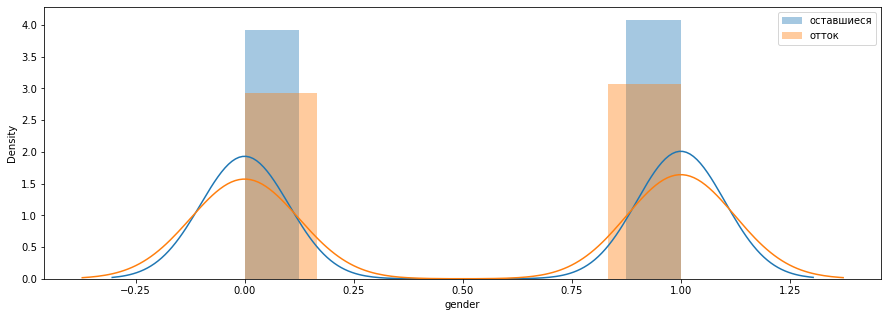

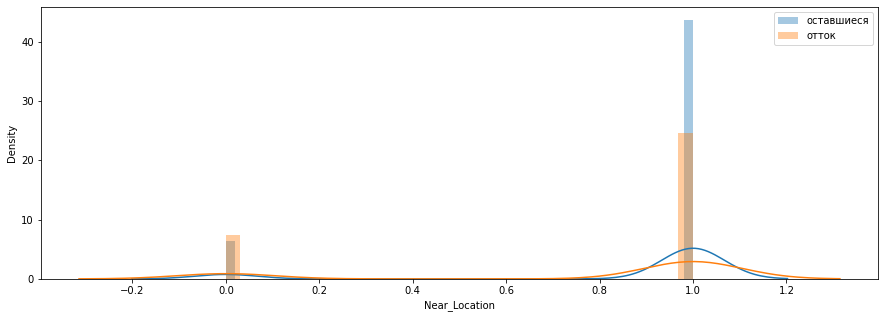

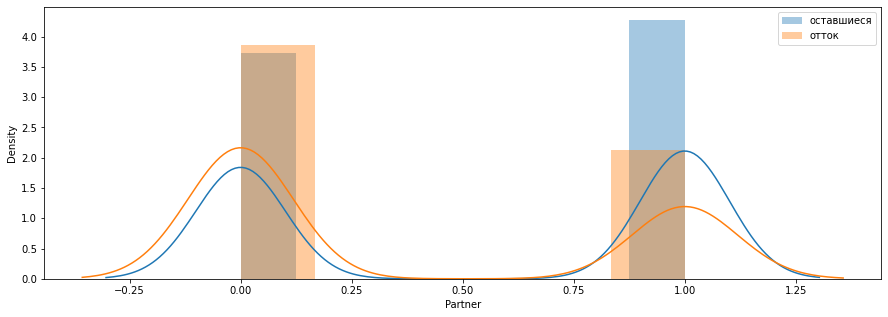

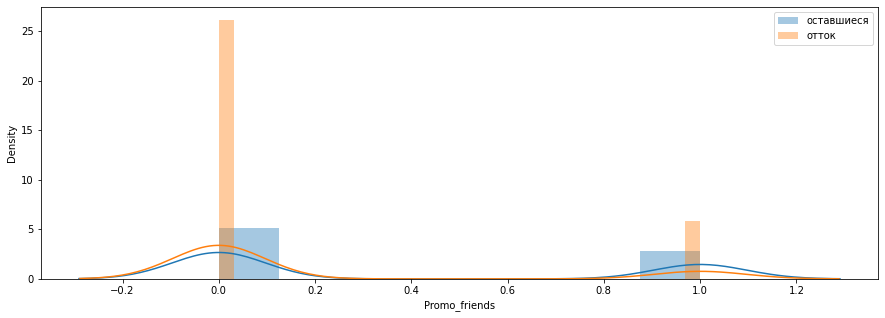

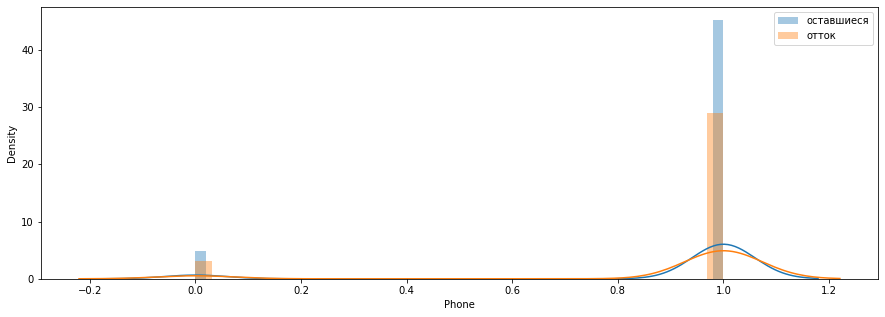

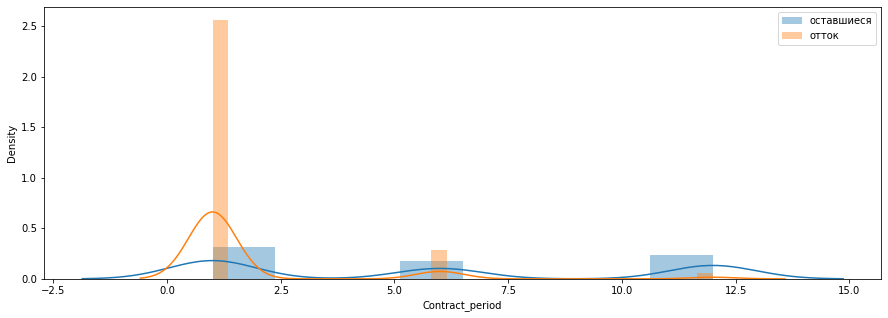

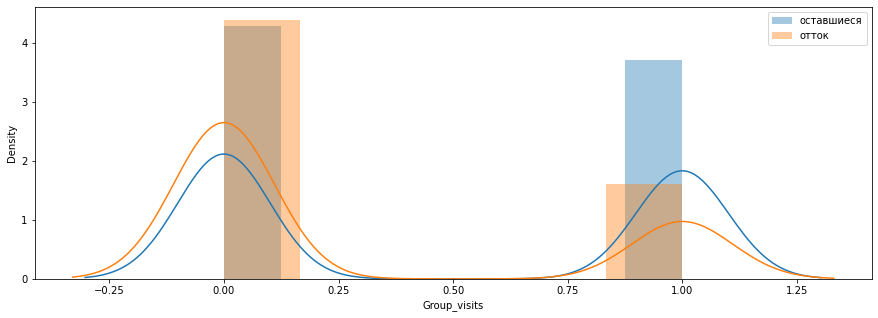

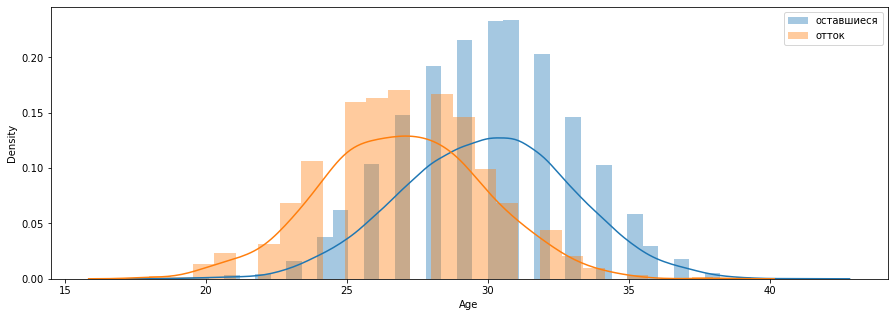

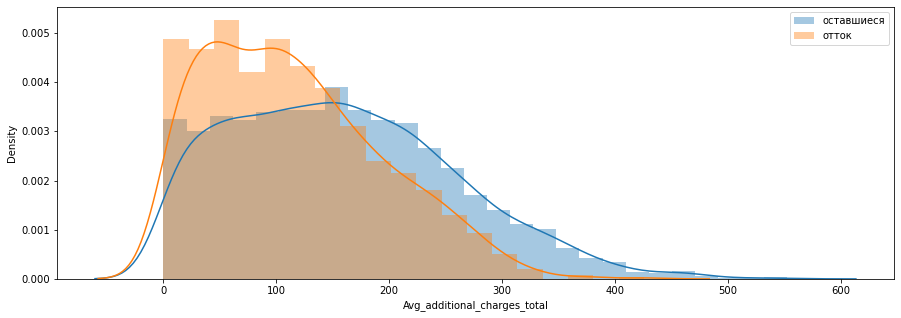

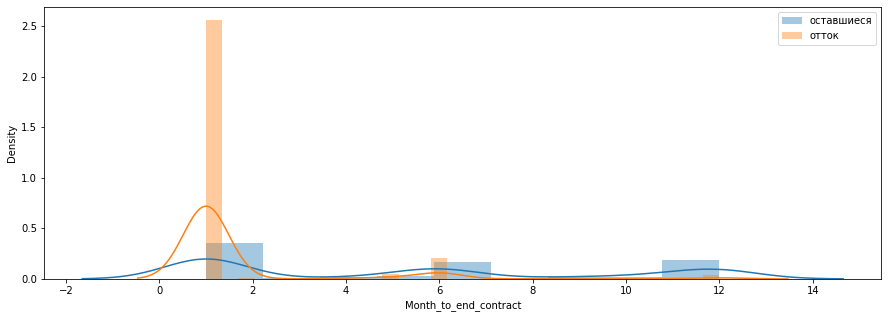

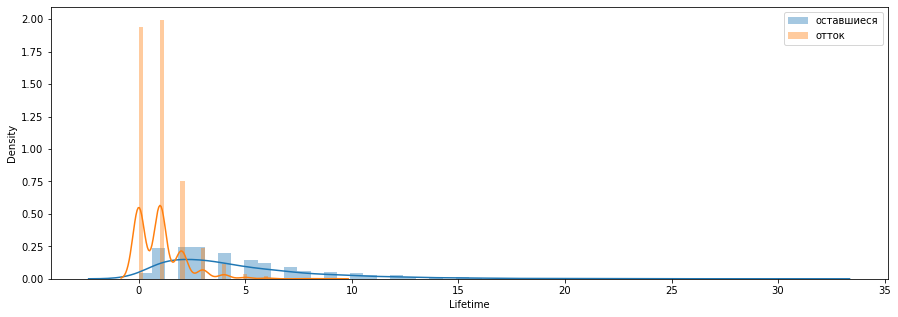

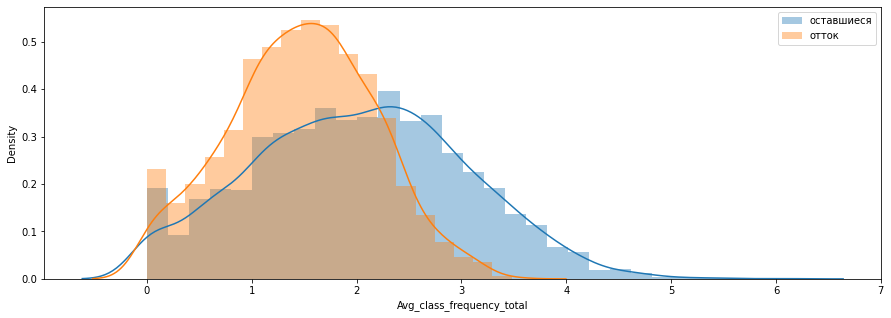

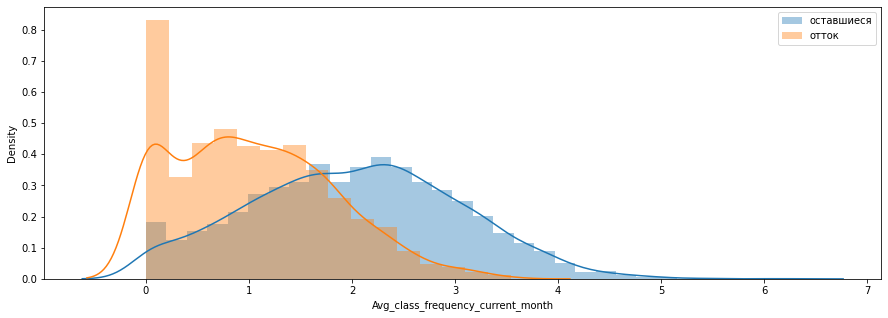

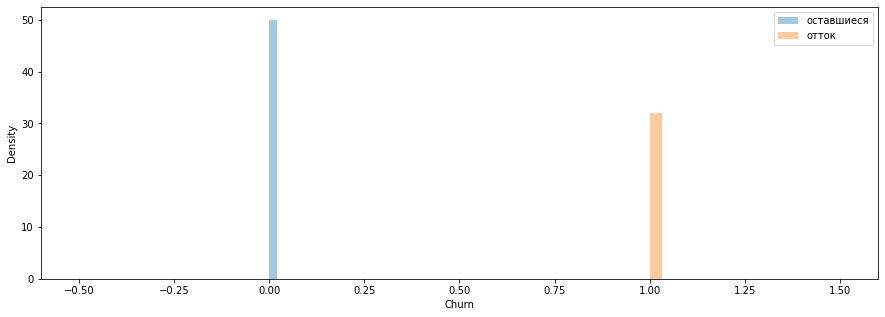

In [10]:
stay = df[df['Churn']==0] # кто остался
away = df[df['Churn']==1] # кто ушёл

columns = df.columns

for col in columns:
    plt.figure(figsize=(15, 5))

    sns.distplot(stay[col], label = 'оставшиеся')
    sns.distplot(away[col], label = 'отток')
    plt.legend()

    plt.show()

Построим матрицу корреляций:

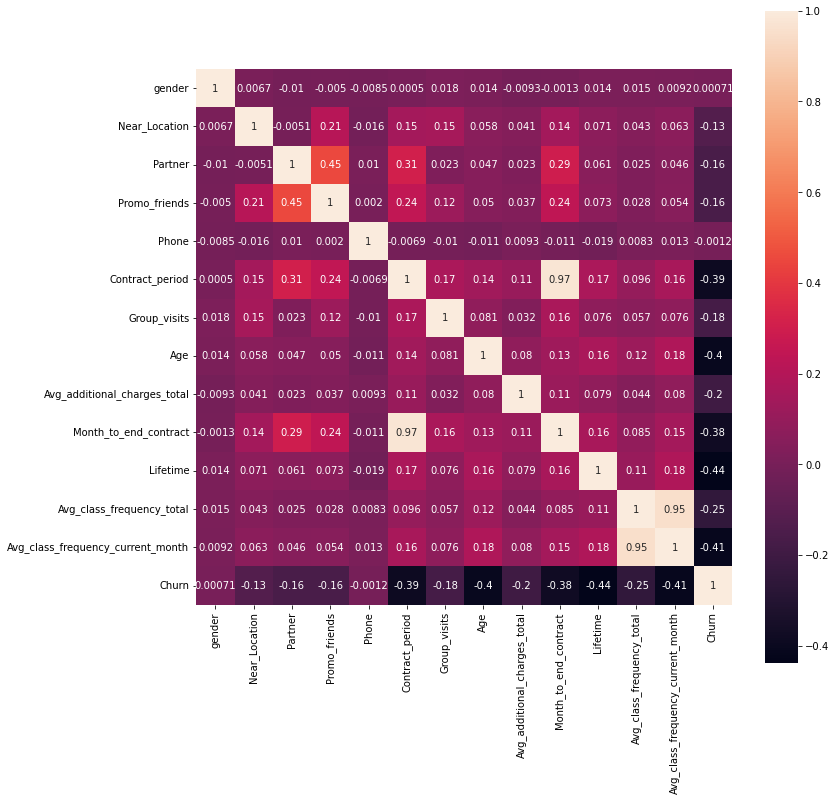

In [11]:
cm = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, square=True)
plt.show()

**Корреляции:**

In [12]:
sum(df['Contract_period'] - df['Month_to_end_contract'])/sum(df['Contract_period'])

0.07658210947930574

**Сильная корреляция** между длительностью текущего действующего абонемента (`Contract_period`) и сроком до окончания текущего действующего абонемента (`Month_to_end_contract`) и небольшая сумма значений их разницы говорит о том, что **срок до окончания абонемента равен или близок к длительности абонемента**.

In [13]:
sum(df['Avg_class_frequency_total'] - df['Avg_class_frequency_current_month'])/sum(df['Avg_class_frequency_total'])

0.05958845974179572

**Сильная корреляция** между средней частотой посещений в неделю за всё время с начала действия абонемента (`Avg_class_frequency_total`) и средней частотой посещений в неделю за предыдущий месяц (`Avg_class_frequency_current_month`) и небольшая сумма значений их разницы говорит о том, что **частота посещений в неделю за всё время близка к средней частоте посещений в неделю за предыдущий месяц**.

Средняя корреляция (0.45) наблюдаются между сотрудниками компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента, `Partner`) и фактом первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента, `Promo_friends`).

Остальное либо слабая корреляция, либо очень слабая.

**Выводы:**

Датасет состоит из 4000 наблюдений - 13 признаков и целевая переменная `Churn`.

Дубликатов, пропусков (пустых значений) и сильных выбросов в датасете нет.

Все признаки или численные, или приведены к численному виду.

Среднее для признаков оттока почти всегда меньше, чем у оставшихся. Среднее для признаков: пола и наличие контактного телефона практически не отличается, что говорит о том, что возможно эти признаки не имеют существенного значения, т.е. **признаки `gender` и `Phone` можно будет исключить**. В тоже время для времени с момента первого обращения в фитнес-центр, длительности текущего действующего абонемента и срок до окончания текущего действующего абонемента среднее отличается в разы.

Сильные корреляции наблюдаются между:
- длительностью текущего действующего абонемента (`Contract_period`) и сроком до окончания текущего действующего абонемента (`Month_to_end_contract`) и небольшая сумма значений их разницы говорит о том, что срок до окончания абонемента равен или близок к длительности абонемента;
- средней частотой посещений в неделю за всё время с начала действия абонемента (`Avg_class_frequency_total`) и средней частотой посещений в неделю за предыдущий месяц (`Avg_class_frequency_current_month`) и небольшая сумма значений их разницы говорит о том, что частота посещений в неделю за всё время близка к средней частоте посещений в неделю за предыдущий месяц.

Таким образом, **можно исключить некоторые признаки:**
- `Contract_period` или `Month_to_end_contract`;
- `Avg_class_frequency_total` или `Avg_class_frequency_current_month`.


## Построим модель прогнозирования оттока клиентов - бинарная классификация клиентов, где целевой признак — факт оттока клиента в следующем месяце:
- разобъём данные на обучающую и валидационную выборку;
- обучим модель на train-выборке двумя способами:
    - логистической регрессией;
    - случайным лесом;
- оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели.

In [14]:
# разделим данные на признаки и целевую переменную
x = df.drop('Churn', axis=1)
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0
)

Масштабирование численных признаков.

Обучаем scaler только на тренировочной выборке.

In [15]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(x_train)

# Преобразуйте обучающий и валидационные наборы данных
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

Логистическая регрессия:

У нас есть мультиколлиниарность, поэтому можно оставить только признаки, корреляция между которыми не превышает высокого, например, порога 0.8, т.е. вручную **исключить признаки:**
- `Contract_period` или `Month_to_end_contract`;
- `Avg_class_frequency_total` или `Avg_class_frequency_current_month`;

либо использовать регуляризацию `Lasso()` или `Ridge()`.

Используем регуляризацию `Lasso()`

In [16]:
# зададим алгоритм для модели
model = Lasso(random_state=0)

# обучим модель
model.fit(x_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
y_pred = model.predict(x_test_st)

# признаки и их веса
features = pd.DataFrame({'feature':x.columns,'coeff':model.coef_})
features['coeff_abs'] = features['coeff'].abs()

# упорядоченный по модулю коэффициентов датафрейм с признаками
print(features.sort_values(by='coeff_abs', ascending=False))

                              feature  coeff  coeff_abs
0                              gender    0.0        0.0
1                       Near_Location   -0.0        0.0
2                             Partner   -0.0        0.0
3                       Promo_friends   -0.0        0.0
4                               Phone   -0.0        0.0
5                     Contract_period   -0.0        0.0
6                        Group_visits   -0.0        0.0
7                                 Age   -0.0        0.0
8        Avg_additional_charges_total   -0.0        0.0
9               Month_to_end_contract   -0.0        0.0
10                           Lifetime   -0.0        0.0
11          Avg_class_frequency_total   -0.0        0.0
12  Avg_class_frequency_current_month   -0.0        0.0


В случае регуляризации с помощью `Lasso()` все коэф. получились равными 0.

Нулевые коэффициенты получаются из-за большого числа alpha - это коэффициент регуляризации. Лассо использует L1 регуляризацию и занижает значения коэффициентов.

*Можно alpha сделать равным 0.1 или ещё меньше.*

Используем регуляризацию `Ridge()`

In [17]:
# зададим алгоритм для модели
model = Ridge(random_state=0)

# обучим модель
model.fit(x_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
y_pred = model.predict(x_test_st)

# признаки и их веса
features = pd.DataFrame({'feature':x.columns,'coeff':model.coef_})
features['coeff_abs'] = features['coeff'].abs()

# упорядоченный по модулю коэффициентов датафрейм с признаками
print(features.sort_values(by='coeff_abs', ascending=False))

                              feature     coeff  coeff_abs
12  Avg_class_frequency_current_month -0.600304   0.600304
11          Avg_class_frequency_total  0.490693   0.490693
10                           Lifetime -0.103858   0.103858
7                                 Age -0.091430   0.091430
5                     Contract_period -0.051893   0.051893
8        Avg_additional_charges_total -0.036943   0.036943
6                        Group_visits -0.028269   0.028269
9               Month_to_end_contract -0.024056   0.024056
2                             Partner -0.014674   0.014674
3                       Promo_friends -0.010948   0.010948
1                       Near_Location -0.009676   0.009676
0                              gender  0.003211   0.003211
4                               Phone -0.000287   0.000287


Оставить только признаки, корреляция между которыми не превышает высокого порога, например, 0.8, т.е. вручную **исключить признаки** (есть 4 варианта, выберем и оставим только лучший по метрикам):

вариант 1: 0.9 / 0.79 / 0.81 / 0.80
- `Month_to_end_contract`;
- `Avg_class_frequency_current_month`.

**вариант 2: 0.9 / 0.79 / 0.82 / 0.81**
- `Month_to_end_contract`;
- `Avg_class_frequency_total`.

вариант 3: 0.9 / 0.79 / 0.82 / 0.81
- `Contract_period`;
- `Avg_class_frequency_total`.

вариант 4: 0.9 / 0.79 / 0.81 / 0.80
- `Contract_period`;
- `Avg_class_frequency_current_month`.

In [18]:
# разделим данные на признаки и целевую переменную
# x = df.drop(['Churn','Month_to_end_contract','Avg_class_frequency_current_month'], axis=1) # вариант 1
x = df.drop(['Churn','Month_to_end_contract','Avg_class_frequency_total'], axis=1) # вариант 2
# x = df.drop(['Churn','Contract_period','Avg_class_frequency_total'], axis=1) # вариант 3
# x = df.drop(['Churn','Contract_period','Avg_class_frequency_current_month'], axis=1) # вариант 4
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0
)
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(x_train)

# Преобразуйте обучающий и валидационные наборы данных
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

In [19]:
# зададим алгоритм для модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(x_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
y_pred = model.predict(x_test_st)

# метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.90
Precision: 0.79
Recall: 0.82
F1: 0.81


Если использовать модель с регуляризацией, то даже в линейных моделях можно не убирать мультиколлинеарные признаки. Мультиколлинеарность - это проблема линейных моделей, более того, она проявляется при расчете коэффициентов линейной модели по формулам. Если использовать градиентный спуск и регуляризацию, то этой проблемы можно избежать.

Случайный лес:

Оставить только признаки, корреляция между которыми не превышает высокого, например, порога 0.8, т.е. вручную **исключить признаки** (есть 4 варианта, выберем и оставим только лучший по метрикам):

вариант 1: 0.89 / 0.79 / 0.76 / 0.77
- `Month_to_end_contract`;
- `Avg_class_frequency_current_month`.

**вариант 2: 0.9 / 0.81 / 0.75 / 0.78**
- `Month_to_end_contract`;
- `Avg_class_frequency_total`.

*вариант 3: 0.91 / 0.82 / 0.78 / 0.80*
- `Contract_period`;
- `Avg_class_frequency_total`.

вариант 4: 0.9 / 0.80 / 0.77 / 0.79
- `Contract_period`;
- `Avg_class_frequency_current_month`.

In [20]:
# разделим данные на признаки и целевую переменную
# x = df.drop(['Churn','Month_to_end_contract','Avg_class_frequency_current_month'], axis=1) # вариант 1
x = df.drop(['Churn','Month_to_end_contract','Avg_class_frequency_total'], axis=1) # вариант 2
# x = df.drop(['Churn','Contract_period','Avg_class_frequency_total'], axis=1) # вариант 3
# x = df.drop(['Churn','Contract_period','Avg_class_frequency_current_month'], axis=1) # вариант 4
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0
)
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(x_train)

# Преобразуйте обучающий и валидационные наборы данных
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

In [21]:
# зададим алгоритм для модели
model = RandomForestClassifier(random_state=0)

# обучим модель
model.fit(x_train_st, y_train)

# бинарный прогноз
y_pred = model.predict(x_test_st)

# метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.75
F1: 0.78


По метрикам `Precision` выше у СЛ, а `Recall` выше у ЛР, поэтому ориентируемся на метрику F1: Логистическая регрессия справилась лучше, чем Случайный лес.

Используя модели с регуляризацией Ridge выявили, что наибольший вес по модулю у признаков (> 0.4):
- Avg_class_frequency_current_month;
- Avg_class_frequency_total;

а наименьший вес у признаков (< 0.015):
- Phone;
- gender;
- Near_Location;
- Promo_friends;
- Partner.

Признаки с весом по модулю в диапазоне [0.05 : 0.11]:
- Lifetime;
- Age;
- Contract_period.

## Кластеризация клиентов

Чтобы исключить влияние оттока на формирование кластеров, его нужно исключить из признаков для расчета матрицы расстояний.

Стандартизируем данные:

In [22]:
# разделим данные на признаки и целевую переменную
x = df.drop('Churn', axis=1)
y = df['Churn']

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(x)

Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

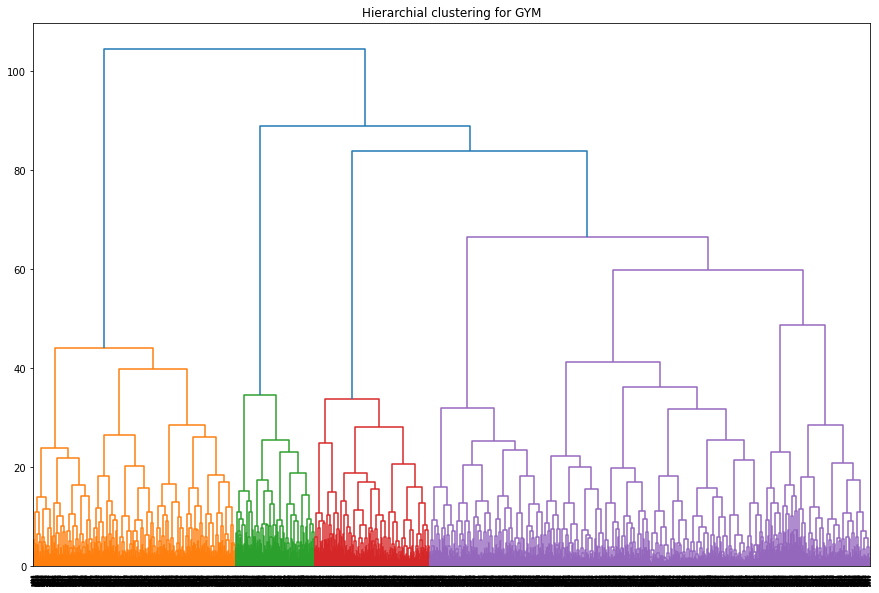

In [23]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

<!-- На основании полученного графика по цвету выделено 5 кластеров. -->
На основании полученного графика по цвету выделено 4 кластера.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [24]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

Посмотрим на средние значения признаков для кластеров:

In [25]:
# выводим статистику по средним значениям наших признаков по кластеру
print(df.groupby('cluster_km').mean())

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.502970       0.959406  0.783168       0.574257  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.559666       0.976134  0.356802       0.230310  0.998807   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                 10.889109      0.542574  29.982178   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.669451      0.473747  30.125298   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

В кластерах 0 и 4 среднее стремится к нулю, а значит отток минимален.

В кластерах 3 и 2 среднее максимально большое, а значит отток в них максимальный.

Отток меньше, чем выше показатель:
- длительности текущего действующего абонемента (`Contract_period`)
- средней частоты посещений в неделю за месяц и за все время (`Avg_class_frequency_`);
- времени с момента первого обращения в фитнес-центр (`Lifetime`);
- суммарной выручки от других услуг (`Avg_additional_charges_total`).

Забавно, что в кластере 3 клиенты строго проживают или работают в районе фитнес-клуба, а в кластере 2 наоборот.

Построим распределения признаков для кластеров:

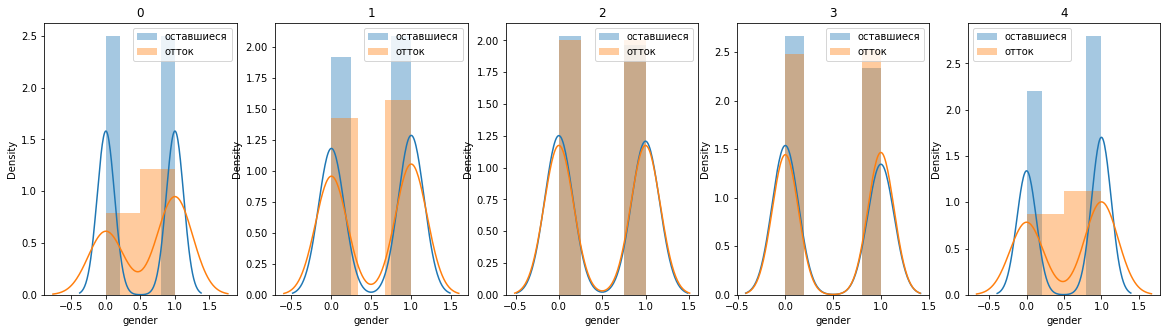

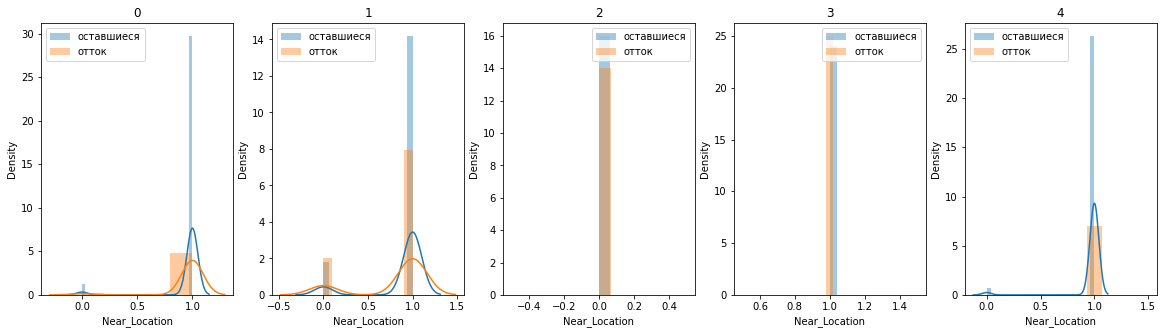

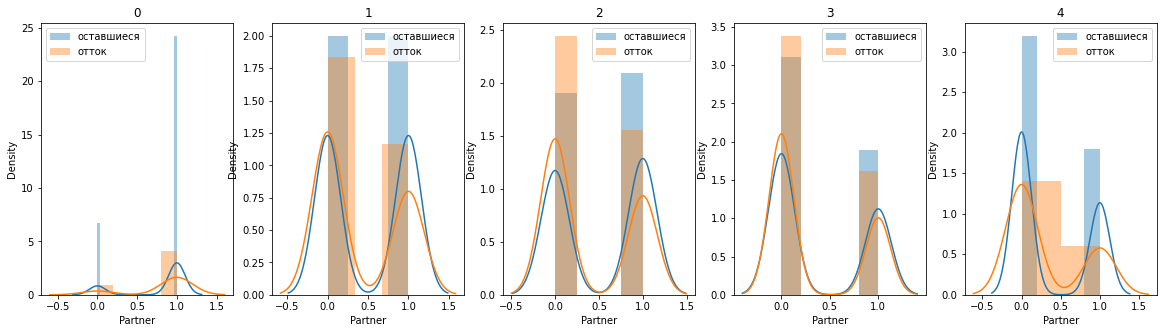

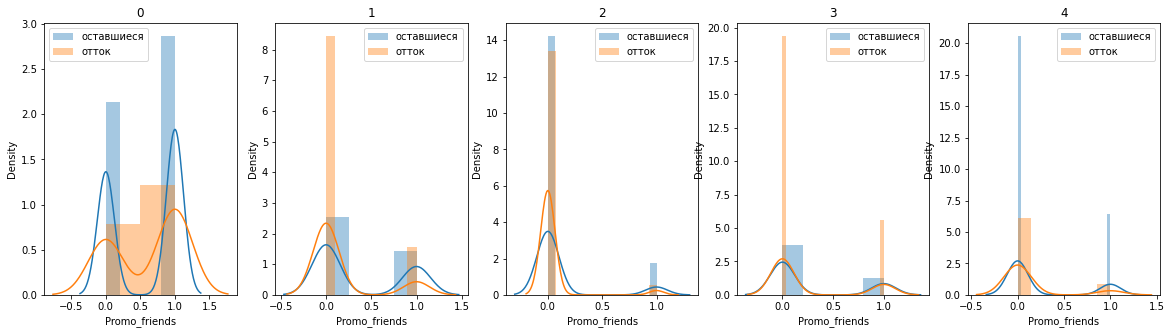

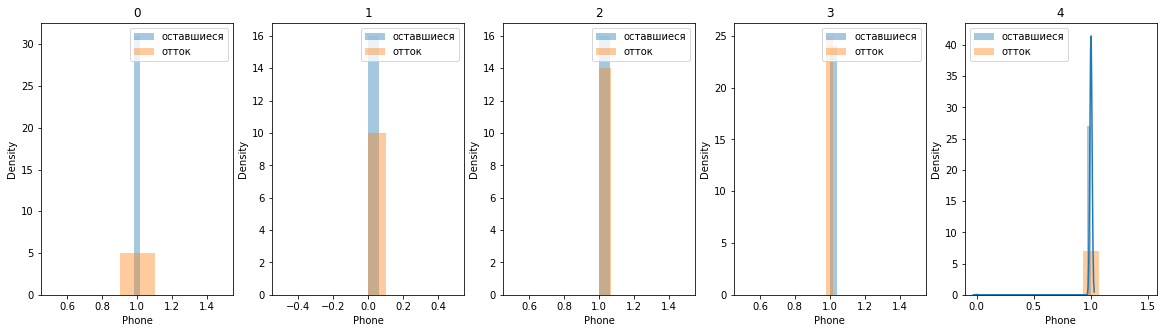

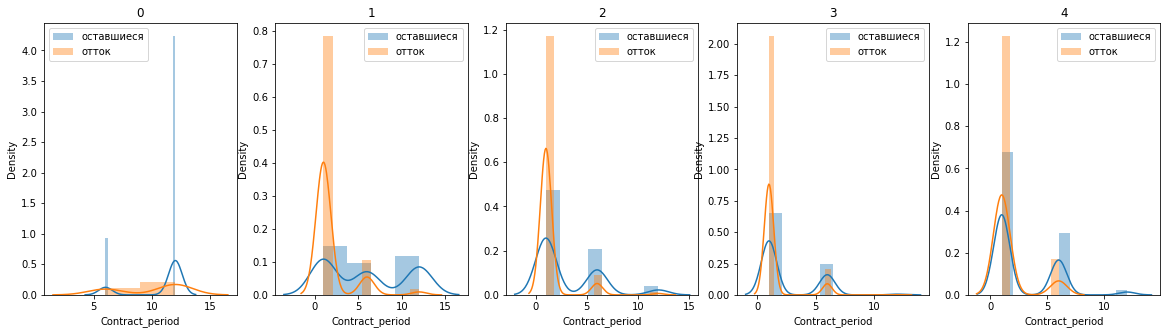

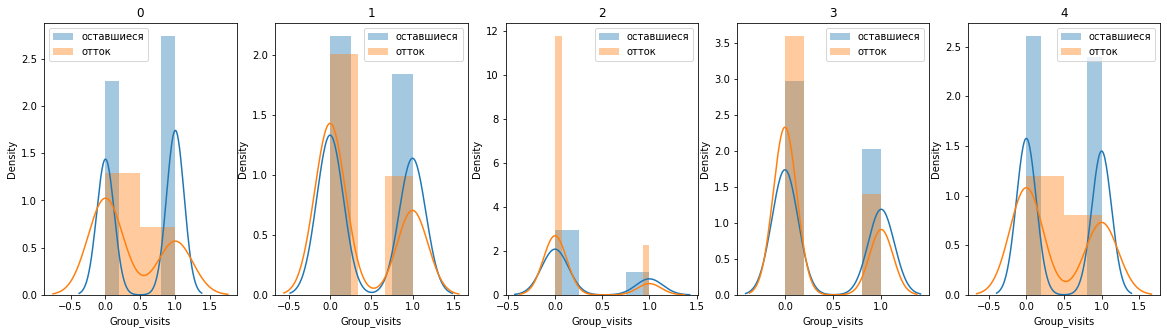

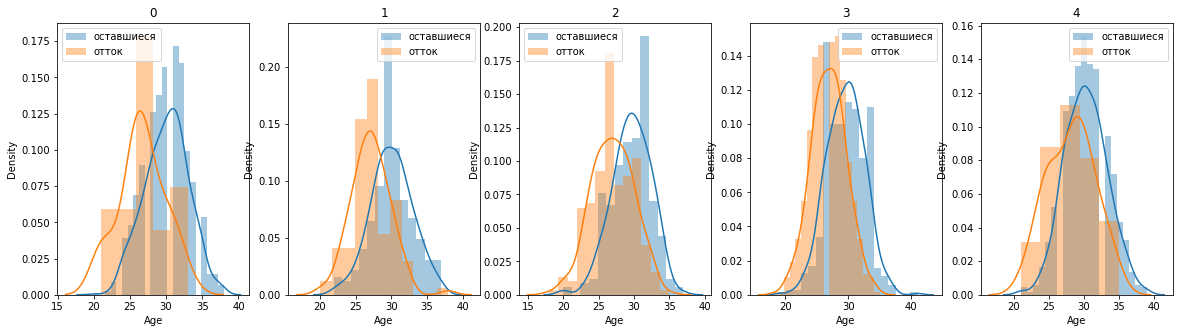

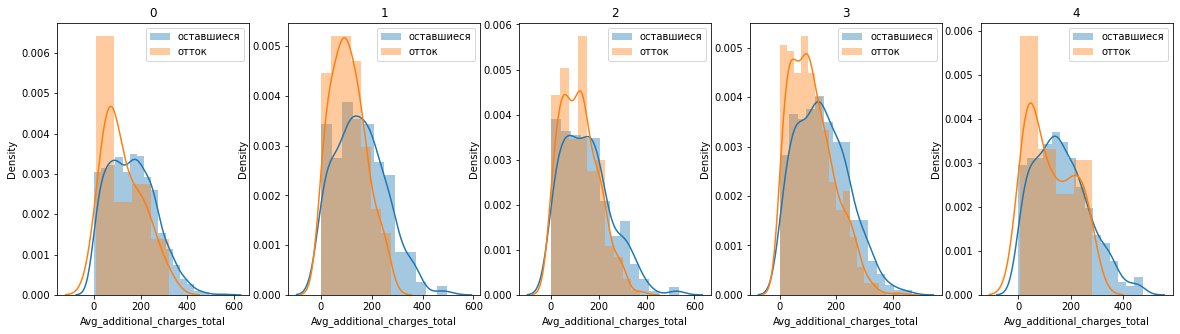

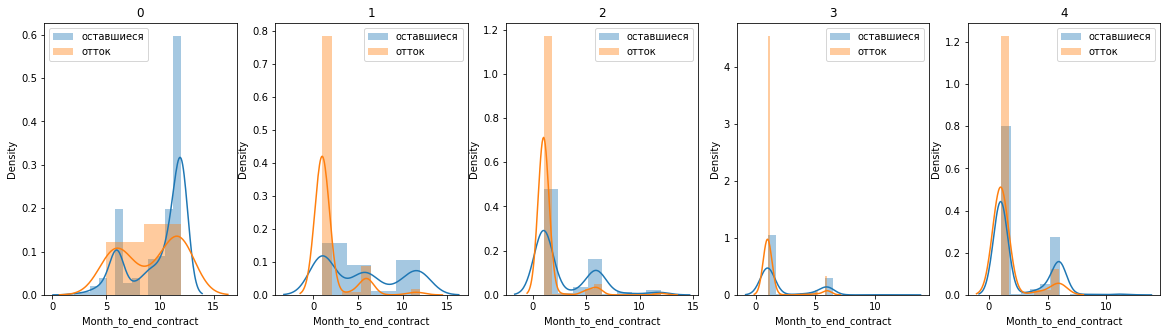

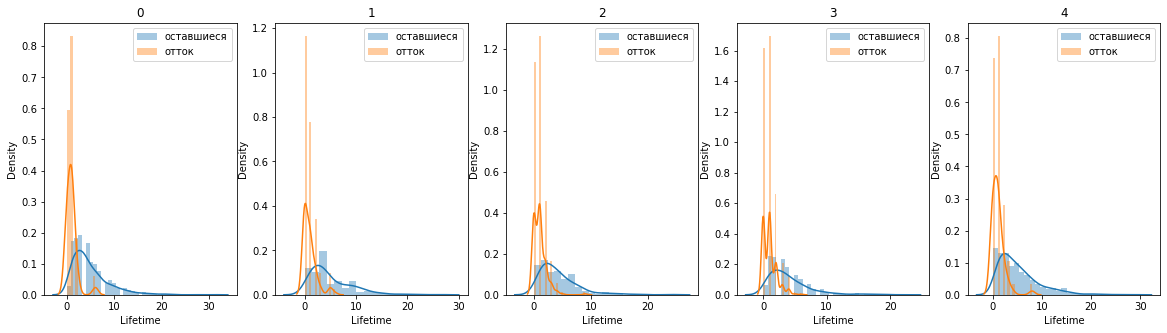

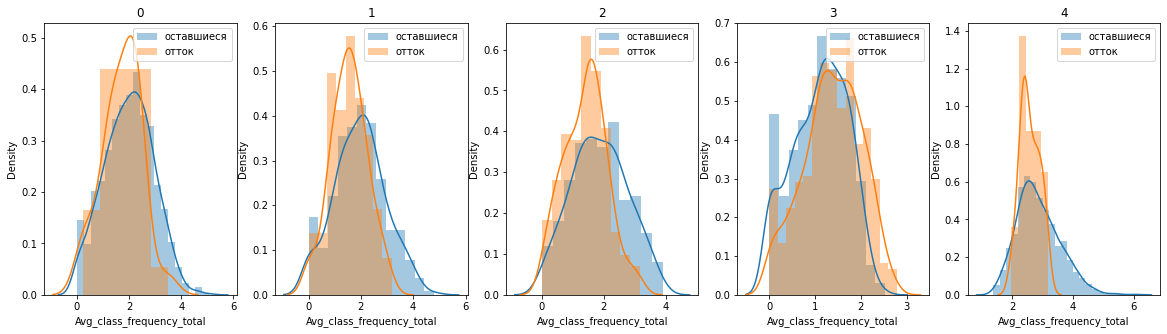

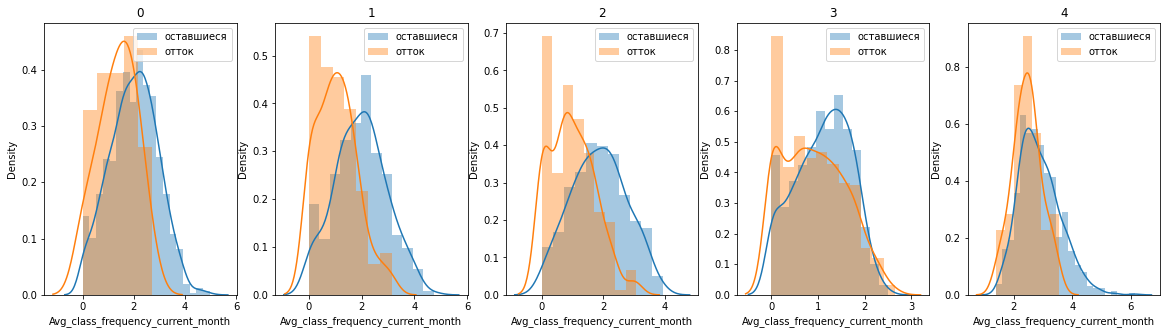

In [26]:
columns = df.columns[:-2]
n_cluster = 5

for col in columns:
    plt.figure(figsize=(20, 5))
    
    for n in range(n_cluster):
        c = df[df['cluster_km']==n]
        stay = c[c['Churn']==0] # кто остался
        away = c[c['Churn']==1] # кто ушёл
        
        plt.subplot(1,n_cluster,n+1)
        sns.distplot(stay[col], label = 'оставшиеся')
        sns.distplot(away[col], label = 'отток')
        plt.title(n)
        plt.legend()

    plt.show()
   

Для каждого полученного кластера посчитаем долю оттока (в процентах, %):

In [27]:
churn = df.groupby('cluster_km').agg({'Churn': ['sum', 'count']})
churn['percent'] = round(churn[('Churn',   'sum')] /
                    churn[('Churn', 'count')] * 100, 2)
churn.sort_values(by='percent', ascending=False)

Churn       percent
             sum count        
cluster_km                    
3            649  1262   51.43
2            224   505   44.36
1            103   385   26.75
4             57   838    6.80
0             28  1010    2.77

Кластеры 3 и 2 наименее надёжны, доля оттока в них 51% и 44% соответственно.

Кластеры 0 и 4 наиболее надёжны, доля оттока в них 3% и 7% соответственно.

## Выводы и базовые рекомендации по работе с клиентами

Всех клиентов сети фитнес-центров ##### поделили на 5 кластеров.<br>
В кластерах 0 и 4 отток минимален, а в кластерах 3 и 2 сильный отток – около половины уходят.

Портрет клиента, генерирующего отток:
- средняя частота посещений 1 раз в неделю за предыдущий месяц (Avg_class_frequency_current_month)
- время с момента первого обращения в фитнес-центр менее 3 месяцев (Lifetime);
- возраст 27-28 лет (Age);
- длительность текущего действующего абонемента один месяц (Contract_period);


Возможные маркетинговые действия по удержанию клиента оттока.
Дать понять клиенту о заинтересованности в нём. Это может быть выражено в обзвонах с целью предложения акций/скидок, новых групповых программ, изменением тренерского состава, составлением индивидуальных программ по тренировкам, питанию. Если клиент в клубе свободный тренер может подойти и скорректировать выполняемое упражнение, похвалить, разъяснить какие-то моменты, при этом важно создать вовлечённость клиента и зону комфорта.